<a href="https://colab.research.google.com/github/Bandi120424/KDT-AI/blob/Month-3/Scene_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터 로드 및 라이브러리 임포트

In [1]:
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
%cd Scene-Classification-Dataset-Split 

Cloning into 'Scene-Classification-Dataset-Split'...
remote: Enumerating objects: 17038, done.
remote: Total 17038 (delta 0), reused 0 (delta 0), pack-reused 17038
Receiving objects: 100% (17038/17038), 136.02 MiB | 26.03 MiB/s, done.
Checking out files: 100% (17035/17035), done.
/content/Scene-Classification-Dataset-Split


In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import torchvision
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [3]:
classes = ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']
train_path = 'train/'
val_path = 'val/'

print("[ 학습 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(train_path + classes[i]))}')

print("[ 검증 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(val_path + classes[i]))}')

[ 학습 데이터셋 ]
클래스 0의 개수: 2105
클래스 1의 개수: 2205
클래스 2의 개수: 2363
클래스 3의 개수: 2438
클래스 4의 개수: 2224
클래스 5의 개수: 2292
[ 검증 데이터셋 ]
클래스 0의 개수: 523
클래스 1의 개수: 540
클래스 2의 개수: 594
클래스 3의 개수: 599
클래스 4의 개수: 560
클래스 5의 개수: 591


### 데이터 증진 (data augmentation), 정규화
- RandomResizedCrop(): 이미지의 일부를 잘라내어 특정 크기로 변형
- RandomHorizontalFlip(): 이미지 좌우 반전
- input Mixup

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train) 
val_dataset = datasets.ImageFolder(val_path, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) #DataLoader: data에 대응하는 label을 붙이고, minibatch 단위로 데이터를 섞어서 리턴 (오버피팅을 방지)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


In [5]:
mixup_alpha = 1.0


def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_with_mixup(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets) # Mixup 진행
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)

#### 전이학습

In [6]:
transforms_train_transferred = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val_transferred = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_transferred = datasets.ImageFolder(train_path, transforms_train_transferred)
val_dataset_transferred = datasets.ImageFolder(val_path, transforms_val_transferred)

train_dataloader_transferred = torch.utils.data.DataLoader(train_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)
val_dataloader_transferred = torch.utils.data.DataLoader(val_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset_transferred))
print('Validation dataset size:', len(val_dataset_transferred))

class_names = train_dataset_transferred.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


### 학습 및 평가 함수 정의

In [7]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

### AlexNet의 변형 아키텍쳐 구현

In [8]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=2)
        # → 차원(dimension): (96 x 64 x 64)
        self.lrn1 =  nn.LocalResponseNorm(5)
        # → 차원(dimension): (96 x 64 x 64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # → 차원(dimension): (96 x 31 x 31)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        # → 차원(dimension): (256 x 31 x 31)
        self.lrn2 =  nn.LocalResponseNorm(5)
        # → 차원(dimension): (256 x 31 x 31)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # → 차원(dimension): (256 x 15 x 15)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        # → 차원(dimension): (384 x 15 x 15)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # → 차원(dimension): (384 x 15 x 15)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        # → 차원(dimension): (256 x 15 x 15)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # → 차원(dimension): (256 x 7 x 7)
        self.fc1 = nn.Linear(256 * 7 * 7, 4096)
        # → 차원(dimension): (4096)
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4096, 6)
        # → 차원(dimension): (6)
        self.dp2 = nn.Dropout(p=0.5)       
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(self.lrn1(x))
        x = F.relu(self.conv2(x))
        x = self.pool2(self.lrn2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)) 		   
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x =  F.relu(self.fc1(x))
        x = self.fc2(self.dp1(x))
        x = self.dp2(x)
	
        return x

#### 평가

In [9]:
import time
import torch.optim as optim


net = AlexNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 30.821163865854555
Train average loss: 0.05063398395953196
[ Validation epoch: 1 ]
Accuarcy: 54.71088934546522
Average loss: 0.0383326744172522
Model saved! (time elapsed: 48.74067521095276)
[ Train epoch: 1 ]
Train accuarcy: 38.97409554560799
Train average loss: 0.045427220683196864
[ Validation epoch: 2 ]
Accuarcy: 55.56207807455239
Average loss: 0.03577239761123008
Model saved! (time elapsed: 90.51253247261047)
[ Train epoch: 2 ]
Train accuarcy: 41.843399134072065
Train average loss: 0.04395696089746597
[ Validation epoch: 3 ]
Accuarcy: 63.428235984737306
Average loss: 0.033053293076294905
Model saved! (time elapsed: 132.18666172027588)
[ Train epoch: 3 ]
Train accuarcy: 42.452484039040144
Train average loss: 0.0429441792263169
[ Validation epoch: 4 ]
Accuarcy: 64.837100088054
Average loss: 0.030313990281969704
Model saved! (time elapsed: 173.97729063034058)
[ Train epoch: 4 ]
Train accuarcy: 43.70000733837235
Train average loss: 0.0419838098565682

정확도/손실 커브 시각화

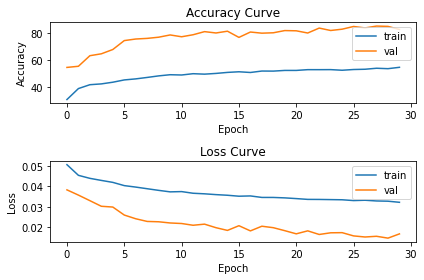

In [10]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

혼동행렬 시각화

In [12]:
# 네트워크에 데이터셋을 입력하여 혼동 행렬(confusion matrix)을 계산하는 함수
def get_confusion_matrix(net, num_classes, data_loader):
    net.eval() # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


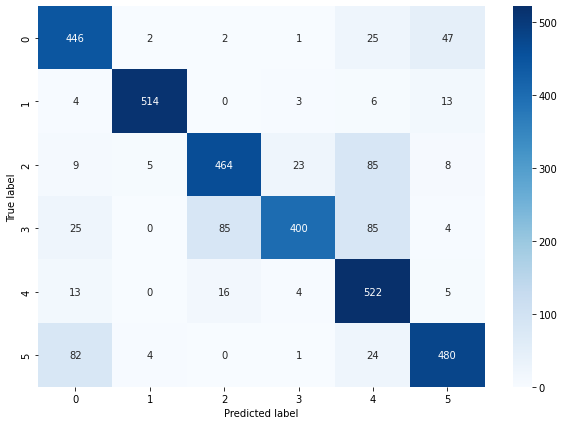

[ 각 클래스에 따른 정확도 ]
tensor([0.8528, 0.9519, 0.7811, 0.6678, 0.9321, 0.8122])
[ 전체 평균 정확도 ]
tensor(0.8295)


In [13]:
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

### pre-trained 모델을 이용하여 분류 모델 생성

In [18]:
from torchvision.models import resnet50, ResNet50_Weights
net = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 20
learning_rate = 0.001 # 일반적으로 fine-tuning을 진행할 때는 학습률(learning rate)을 낮게 설정
file_name = "ResNet50Transferred.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train_with_mixup(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 59.60334667738502
Train average loss: 0.07216351189459028
[ Validation epoch: 1 ]
Accuarcy: 86.41033167009098
Average loss: 0.027823242099448878
Model saved! (time elapsed: 164.8102355003357)
[ Train epoch: 1 ]
Train accuarcy: 64.97423519088434
Train average loss: 0.06428391035500491
[ Validation epoch: 2 ]
Accuarcy: 88.75843850895215
Average loss: 0.025998962403988257
Model saved! (time elapsed: 327.29100584983826)
[ Train epoch: 2 ]
Train accuarcy: 65.61703424479829
Train average loss: 0.06300752379621843
[ Validation epoch: 3 ]
Accuarcy: 88.05400645729381
Average loss: 0.024794522345958303
Model saved! (time elapsed: 490.5914297103882)
[ Train epoch: 3 ]
Train accuarcy: 66.39579204246778
Train average loss: 0.06140540442568563
[ Validation epoch: 4 ]
Accuarcy: 90.66627531552686
Average loss: 0.021962546472557135
Model saved! (time elapsed: 652.8563132286072)
[ Train epoch: 4 ]
Train accuarcy: 66.99313453977514
Train average loss: 0.0601166271735612

정확도/손실 커브 시각화

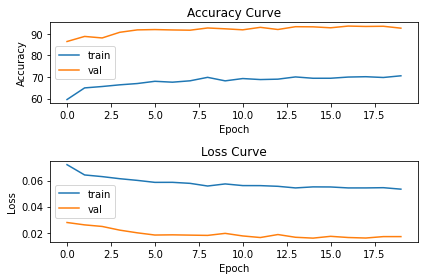

In [19]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()